# Test notebook for Fall 2023 DM Acceptance Test Campaign

This test will be executed on the LSST Science Platform Notebook Aspect, initialized with Science Pipelines release `w_2023_37`.

### Test case LVV-T41: Verify implementation of Generate PSF for Visit Images
Verify that Processed Visit Images produced by the DRP and AP pipelines are associated with
a model from which one can obtain an image of the PSF given a point on the image.

In [1]:
# Confirm that the version of the Science Pipelines is w_2023_37:
! echo $HOSTNAME
! eups list -s | grep lsst_distrib

jcarlin-nb
lsst_distrib          g4213664e8e+da93b84f60 	current w_2023_37 setup


In [2]:
from lsst.daf.butler import Butler
import lsst.geom as geom
from lsst.afw.image import Exposure, PARENT

In [3]:
import numpy as np
import random

from astropy.visualization import (MinMaxInterval, AsinhStretch, ZScaleInterval, LogStretch, LinearStretch,
                                   ImageNormalize)

In [4]:
# Set plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
zscale = ZScaleInterval()

# Set up some plotting defaults:
plt.rcParams.update({'figure.figsize' : (12, 8)})
plt.rcParams.update({'font.size' : 12})
plt.rcParams.update({'axes.linewidth' : 3})
plt.rcParams.update({'axes.labelweight' : 3})
plt.rcParams.update({'axes.titleweight' : 3})
plt.rcParams.update({'ytick.major.width' : 3})
plt.rcParams.update({'ytick.minor.width' : 2})
plt.rcParams.update({'ytick.major.size' : 8})
plt.rcParams.update({'ytick.minor.size' : 5})
plt.rcParams.update({'xtick.major.size' : 8})
plt.rcParams.update({'xtick.minor.size' : 5})
plt.rcParams.update({'xtick.major.width' : 3})
plt.rcParams.update({'xtick.minor.width' : 2})
plt.rcParams.update({'xtick.direction' : 'in'})
plt.rcParams.update({'ytick.direction' : 'in'})

We will use HSC-RC2, as processed using `w_2023_32`, which is the most recent reprocessing of RC2 data.

In [5]:
# The output repo is tagged with the Jira ticket number "DM-40356":

repo = '/repo/main'
rc2_collection = 'HSC/runs/RC2/w_2023_32/DM-40356'

In [6]:
# Initialize the butler repo:
butler = Butler(repo, collections=rc2_collection)

#### Query for all visits in _grizy_ bands:

In [7]:
data_ids = []

for data_id in butler.registry.queryDataIds(
    ["visit", "detector"],
    instrument="HSC",
    datasets="calexp",
    collections=rc2_collection,
    where="(band='g' OR band='r' OR band='i' OR band='z' OR band='y') AND skymap='hsc_rings_v1'"):
    data_ids.append(data_id.full)

#### Select 12 visit/detector images at random:

In [8]:
# Select some visit/tract/patch combinations from these at random:
numvisits = 12
dataid_sel = random.choices(data_ids, k=numvisits)

for d in dataid_sel:
    print(d)

{band: 'y', instrument: 'HSC', detector: 43, physical_filter: 'HSC-Y', visit: 328}
{band: 'y', instrument: 'HSC', detector: 83, physical_filter: 'HSC-Y', visit: 36838}
{band: 'i', instrument: 'HSC', detector: 103, physical_filter: 'HSC-I', visit: 1280}
{band: 'y', instrument: 'HSC', detector: 77, physical_filter: 'HSC-Y', visit: 350}
{band: 'z', instrument: 'HSC', detector: 1, physical_filter: 'HSC-Z', visit: 36444}
{band: 'g', instrument: 'HSC', detector: 60, physical_filter: 'HSC-G', visit: 26036}
{band: 'y', instrument: 'HSC', detector: 62, physical_filter: 'HSC-Y', visit: 22606}
{band: 'z', instrument: 'HSC', detector: 25, physical_filter: 'HSC-Z', visit: 27116}
{band: 'i', instrument: 'HSC', detector: 54, physical_filter: 'HSC-I', visit: 36214}
{band: 'i', instrument: 'HSC', detector: 13, physical_filter: 'HSC-I', visit: 1238}
{band: 'i', instrument: 'HSC', detector: 88, physical_filter: 'HSC-I', visit: 1308}
{band: 'r', instrument: 'HSC', detector: 50, physical_filter: 'HSC-R', v

#### Extract the `calexp` images and datarefs associated with the randomly-selected dataIds:

In [9]:
calexps = []
psfs = []
datarefs = []

for did in dataid_sel:
    # Sometimes CCDs fail, so test whether the dataset exists before grabbing it:
    if butler.exists('calexp', did):
        calexp = butler.get('calexp', dataId = did)
        calexps.append(calexp)
        finalVisitSummary = butler.get('finalVisitSummary', dataId = did)
        fvs = finalVisitSummary.find(did['detector'])
        psfs.append(fvs.getPsf())
        datarefs.append(did)

#### For each of the selected visit/CCD combinations, pick a random (X,Y) coordinate, extract the PSF, and plot an image of the PSF.

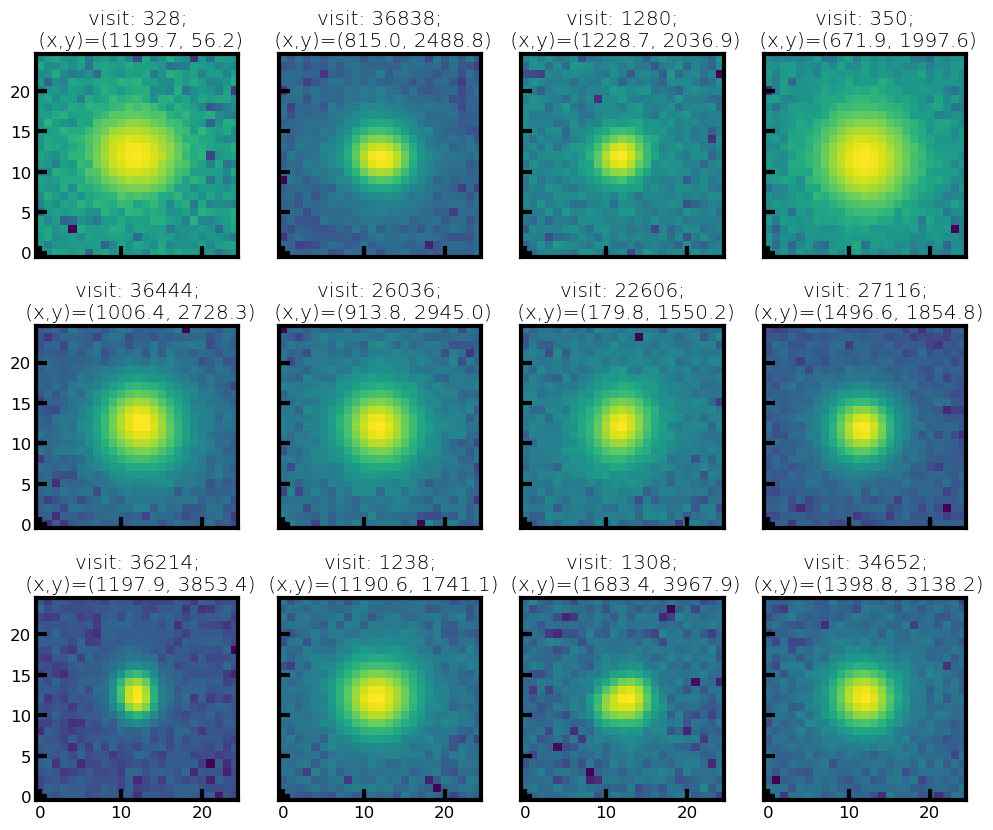

In [10]:
ncols = 4
nrows = numvisits/ncols # 4 plots per row
f, ax = plt.subplots(nrows=int(np.ceil(nrows)), ncols=int(ncols), sharey=True, sharex=True, figsize=(12,10))
axnum = 0
axs = ax.flatten()

for i in range(len(psfs)):
    psf = psfs[i]
    xsize = calexps[i].getDimensions().getX()
    ysize = calexps[i].getDimensions().getY()
    # Select a random point on the image and extract the PSF at that point:
    xpt = random.random()*xsize
    ypt = random.random()*ysize
    psfimage = psf.computeImage(geom.PointD(xpt, ypt))
    img = psfimage.array

    # Create an ImageNormalize object
    norm = ImageNormalize(img, interval=MinMaxInterval(),
                          stretch=LogStretch())

    axs[axnum].set_title('visit: '+str(datarefs[axnum]['visit'])+';\n (x,y)=('+str(round(xpt,1))+', '+str(round(ypt,1))+')')
    axs[axnum].imshow(img, norm=norm, origin='lower')
    axnum += 1


### Now confirm that the PSF is reasonably well-matched to stellar images by selecting a star in each image and subtracting the PSF at the star's position:

In [11]:
# Pick a bright star that was used to fit the PSF, and one that was used to calibrate the photometry:
src = butler.get('src', dataId=datarefs[0])

# Select stars used for fitting the PSF and photometric calibration:
psf_selection = src['calib_psf_used']
photcalib_selection = src['calib_photometry_used']

# Pick one from each table at random:
psf_src = random.choice(src[psf_selection])
photcalib_src = random.choice(src[photcalib_selection])

In [12]:
# Get the coordinates of the PSF star:
radec_psf_src = psf_src.getCoord()

In [14]:
wcs = calexps[0].getWcs()

cutoutSize = geom.ExtentI(100, 100) # size of cutout in pixels
xy = geom.Point2I(wcs.skyToPixel(radec_psf_src)) # central XY coordinate of our star's RA, Dec position

# Create the bounding box:
bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)

# Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
xy0 = calexps[0].getXY0() 

# Postage stamp image only, using the bbox defined above:
parameters = {'bbox': bbox}
cutout_image = butler.get('calexp', parameters=parameters, dataId=datarefs[0])
# Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
xy0_cutout = cutout_image.getXY0() 

#### Create a scaled image of the PSF, and subtract it from the cutout image:

In [15]:
psf = psfs[0]
model = Exposure(cutout_image.getBBox(), dtype=np.float32)
model.setPsf(psf)
psfImage = psf.computeImage(psf_src.getCentroid())
flux = psf_src['base_PsfFlux_instFlux']-(psf_src['base_PsfFlux_area']*psf_src['base_LocalBackground_instFlux'])
psfBBox = psfImage.getBBox()
model.image[psfBBox, PARENT].scaledPlus(flux, psfImage.convertF())
residuals = cutout_image.clone()
residuals.image -= model.image

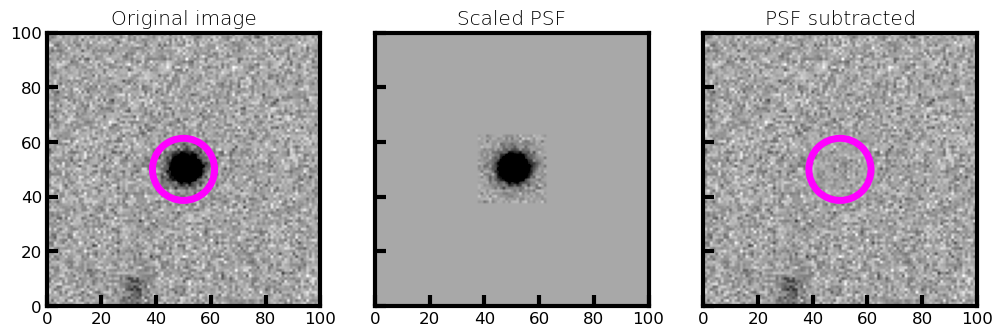

In [16]:
f, ax = plt.subplots(nrows=1, ncols=3, sharey=True, sharex=True, figsize=(12,6))
axs = ax.flatten()

vmin0, vmax0 = zscale.get_limits(cutout_image.image.array)
# Get the dimensions of the image so we can set plot limits
imsize = cutout_image.getDimensions()
axs[0].imshow(cutout_image.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
# Set the plot range to the dimensions:
axs[0].set_xlim(0,imsize[0])
axs[0].set_ylim(0,imsize[1])
axs[0].set_title('Original image')
axs[0].scatter(xy.getX()-xy0_cutout.getX(), xy.getY()-xy0_cutout.getY(), color='none', edgecolor='magenta', s=2000, linewidth=5)

# Get the dimensions of the image so we can set plot limits
imsize = model.image.getDimensions()
axs[1].imshow(model.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
# Set the plot range to the dimensions:
axs[1].set_xlim(0,imsize[0])
axs[1].set_ylim(0,imsize[1])
axs[1].set_title('Scaled PSF')

# Get the dimensions of the image so we can set plot limits
imsize = residuals.image.getDimensions()
axs[2].imshow(residuals.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
# Set the plot range to the dimensions:
axs[2].set_xlim(0,imsize[0])
axs[2].set_ylim(0,imsize[1])
axs[2].set_title('PSF subtracted')
axs[2].scatter(xy.getX()-xy0_cutout.getX(), xy.getY()-xy0_cutout.getY(), color='none', edgecolor='magenta', s=2000, linewidth=5)



### Check the images of some PSF stars, and see how well the PSF matches the stellar image:
For the 12 images selected at random, pick (again, at random) a star that was used in creation of the PSF (using the "calib_psf_used" flag) and look at (a) its image, (b) an image of the scaled PSF at its position, and (c) the residuals after subtracting the scaled PSF from the original image.

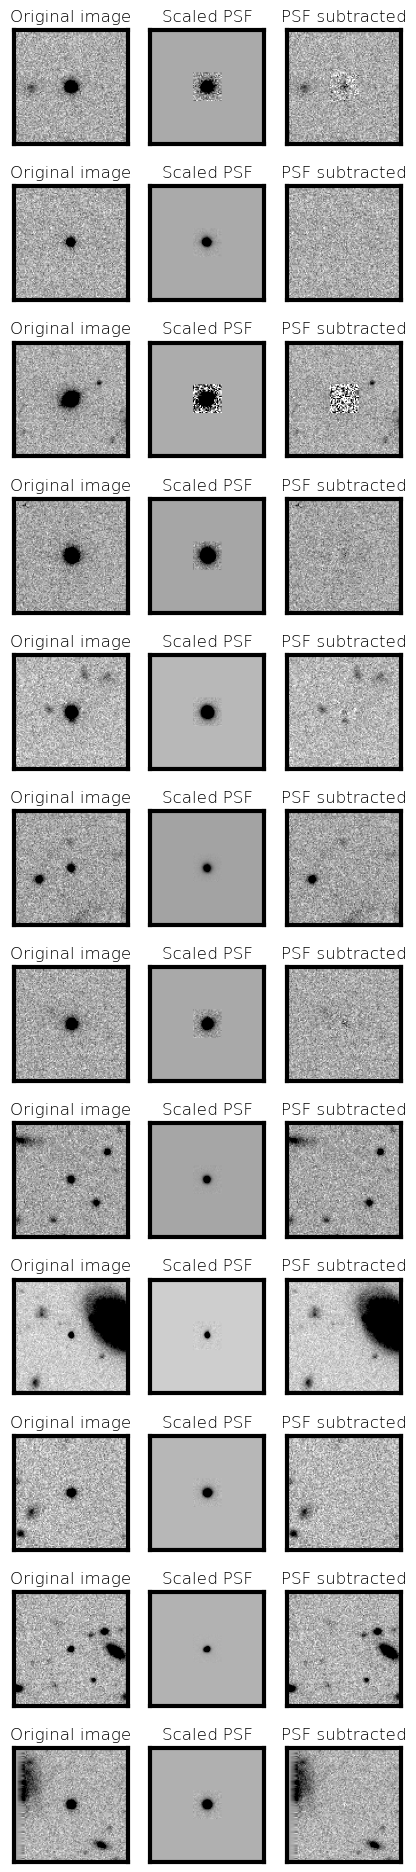

In [17]:
ncols = 3
nrows = numvisits # 4 plots per row
f, ax = plt.subplots(nrows=int(nrows), ncols=int(ncols), sharey=True, sharex=True, figsize=(5,24))
axnum = 0
axs = ax.flatten()
plt.rcParams.update({'font.size' : 10})

for i in range(len(calexps)):
    c = calexps[i]
    dataid = datarefs[i]
    # Pick a bright star that was used to fit the PSF:
    src = butler.get('src', dataId=dataid)

    # Get the WCS for this calexp:
    wcs = c.getWcs()

    # size of image cutout in pixels
    imsize = 100
    cutoutSize = geom.ExtentI(imsize, imsize)

    # Select a PSF star:
    psf_selection = src['calib_psf_used']

    # Pick one from the table at random, but require it to have coordinates
    #   such that the bounding box will not extend beyond the CCD's border:
    oksrc = False
    while not oksrc:
        calexp_dimen = c.getDimensions()
        psf_src = random.choice(src[psf_selection])
        xy = psf_src.getCentroid()
        if (xy.getX() > imsize/2.0) and (xy.getX() < calexp_dimen[0]-imsize/2.0) and\
           (xy.getY() > imsize/2.0) and (xy.getY() < calexp_dimen[1]-imsize/2.0):
            oksrc = True

            
    xy = geom.Point2I(xy)

    # Create the bounding box:
    bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)

    # Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
    xy0 = c.getXY0() 

    # Postage stamp image only, using the bbox defined above:
    parameters = {'bbox': bbox}
    cutout_image = butler.get('calexp', parameters=parameters, dataId=dataid)
    # Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
    xy0_cutout = cutout_image.getXY0() 
    
    psf = psfs[i]
    model = Exposure(cutout_image.getBBox(), dtype=np.float32)
    model.setPsf(psf)
    psfImage = psf.computeImage(psf_src.getCentroid())
    flux = psf_src['base_PsfFlux_instFlux']-(psf_src['base_PsfFlux_area']*psf_src['base_LocalBackground_instFlux'])
    psfBBox = psfImage.getBBox()
    model.image[psfBBox, PARENT].scaledPlus(flux, psfImage.convertF())
    residuals = cutout_image.clone()
    residuals.image -= model.image
    
    vmin0, vmax0 = zscale.get_limits(cutout_image.image.array)
    # Get the dimensions of the image so we can set plot limits
    imsize = cutout_image.getDimensions()
    axs[axnum].imshow(cutout_image.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
    # Set the plot range to the dimensions:
    axs[axnum].set_xlim(0,imsize[0])
    axs[axnum].set_ylim(0,imsize[1])
    axs[axnum].set_title('Original image')
    axs[axnum].get_xaxis().set_visible(False)
    axs[axnum].get_yaxis().set_visible(False)

    axnum += 1

    # Get the dimensions of the image so we can set plot limits
    imsize = model.image.getDimensions()
    axs[axnum].imshow(model.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
    # Set the plot range to the dimensions:
    axs[axnum].set_xlim(0,imsize[0])
    axs[axnum].set_ylim(0,imsize[1])
    axs[axnum].set_title('Scaled PSF')
    axs[axnum].get_xaxis().set_visible(False)
    axs[axnum].get_yaxis().set_visible(False)
    
    axnum += 1

    # Get the dimensions of the image so we can set plot limits
    imsize = residuals.image.getDimensions()
    axs[axnum].imshow(residuals.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
    # Set the plot range to the dimensions:
    axs[axnum].set_xlim(0,imsize[0])
    axs[axnum].set_ylim(0,imsize[1])
    axs[axnum].set_title('PSF subtracted')
    axs[axnum].get_xaxis().set_visible(False)
    axs[axnum].get_yaxis().set_visible(False)

    axnum += 1


### Check the images of some bright photometric calibration stars, and see how well the PSF matches the stellar image:
For the 12 images selected at random, pick (again, at random) a star that was used for photometric calibration (using the "calib_photometry_used" flag) and look at (a) its image, (b) an image of the scaled PSF at its position, and (c) the residuals after subtracting the scaled PSF from the original image.

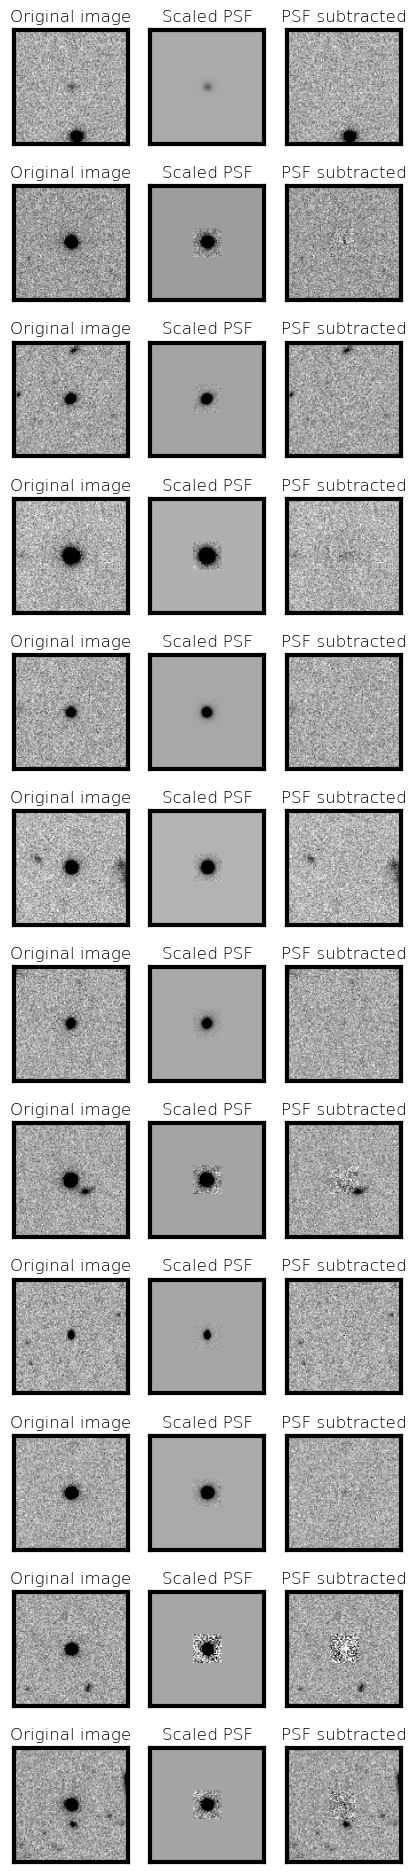

In [18]:
ncols = 3
nrows = numvisits # 4 plots per row
f, ax = plt.subplots(nrows=int(nrows), ncols=int(ncols), sharey=True, sharex=True, figsize=(5,24))
axnum = 0
axs = ax.flatten()
plt.rcParams.update({'font.size' : 10})

for i in range(len(calexps)):
    c = calexps[i]
    dataid = datarefs[i]
    # Pick a bright star that was used to fit the PSF:
    src = butler.get('src', dataId=dataid)

    # Get the WCS for this calexp:
    wcs = c.getWcs()

    # size of image cutout in pixels
    imsize = 100
    cutoutSize = geom.ExtentI(imsize, imsize)

    # Select a photometric calibration star:
    photcalib_selection = src['calib_photometry_used']

    # Pick one from the table at random, but require it to have coordinates
    #   such that the bounding box will not extend beyond the CCD's border:
    oksrc = False
    while not oksrc:
        calexp_dimen = c.getDimensions()
        photcalib_src = random.choice(src[photcalib_selection])
        xy = photcalib_src.getCentroid()
        if (xy.getX() > imsize/2.0) and (xy.getX() < calexp_dimen[0]-imsize/2.0) and\
           (xy.getY() > imsize/2.0) and (xy.getY() < calexp_dimen[1]-imsize/2.0):
            oksrc = True

            
    xy = geom.Point2I(xy)

    # Create the bounding box:
    bbox = geom.Box2I(xy - cutoutSize//2, cutoutSize)

    # Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
    xy0 = c.getXY0() 

    # Postage stamp image only, using the bbox defined above:
    parameters = {'bbox': bbox}
    cutout_image = butler.get('calexp', parameters=parameters, dataId=dataid)
    # Because an entire tract shares a WCS, the corner of the patch (or cutout) isn't necessarily at (X,Y)=(0,0). Get the XY0 pixel values:
    xy0_cutout = cutout_image.getXY0() 
    
    psf = psfs[i]
    model = Exposure(cutout_image.getBBox(), dtype=np.float32)
    model.setPsf(psf)
    psfImage = psf.computeImage(photcalib_src.getCentroid())
    flux = photcalib_src['base_PsfFlux_instFlux']-(photcalib_src['base_PsfFlux_area']*photcalib_src['base_LocalBackground_instFlux'])
    psfBBox = psfImage.getBBox()
    model.image[psfBBox, PARENT].scaledPlus(flux, psfImage.convertF())
    residuals = cutout_image.clone()
    residuals.image -= model.image
    
    vmin0, vmax0 = zscale.get_limits(cutout_image.image.array)
    # Get the dimensions of the image so we can set plot limits
    imsize = cutout_image.getDimensions()
    axs[axnum].imshow(cutout_image.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
    # Set the plot range to the dimensions:
    axs[axnum].set_xlim(0,imsize[0])
    axs[axnum].set_ylim(0,imsize[1])
    axs[axnum].set_title('Original image')
    axs[axnum].get_xaxis().set_visible(False)
    axs[axnum].get_yaxis().set_visible(False)

    axnum += 1

    # Get the dimensions of the image so we can set plot limits
    imsize = model.image.getDimensions()
    axs[axnum].imshow(model.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
    # Set the plot range to the dimensions:
    axs[axnum].set_xlim(0,imsize[0])
    axs[axnum].set_ylim(0,imsize[1])
    axs[axnum].set_title('Scaled PSF')
    axs[axnum].get_xaxis().set_visible(False)
    axs[axnum].get_yaxis().set_visible(False)
    
    axnum += 1

    # Get the dimensions of the image so we can set plot limits
    imsize = residuals.image.getDimensions()
    axs[axnum].imshow(residuals.image.array, vmin=vmin0, vmax=vmax0, cmap='binary')
    # Set the plot range to the dimensions:
    axs[axnum].set_xlim(0,imsize[0])
    axs[axnum].set_ylim(0,imsize[1])
    axs[axnum].set_title('PSF subtracted')
    axs[axnum].get_xaxis().set_visible(False)
    axs[axnum].get_yaxis().set_visible(False)

    axnum += 1


### Use the "hasPsf" method to check whether a larger number of the visit images have an associated PSF model:
A simple way to confirm that a given `calexp` image has a PSF is via the method: `calexp.hasPsf()`.

(Note: we use only a randomly-selected subset of images because it takes too long to extract the calexp for all images in the repository.)

In [19]:
# Select some visit/detector combinations from the repo at random:
numvisits_boolcheck = 1000
img_sel_boolcheck = random.choices(datarefs, k=numvisits_boolcheck)

In [20]:
# Check a larger number of (randomly-selected) CCDs on each of a subset of datarefs:
psfflags = []
datarefs_boolcheck = []

# Loop over the randomly selected datarefs:
for did in img_sel_boolcheck:
    # Sometimes CCDs fail, so test whether the dataset exists before grabbing it:
    if butler.exists('calexp', did):
        calexp = butler.get('calexp', dataId = did)
        psfflags.append(calexp.hasPsf())
        datarefs_boolcheck.append(did)


### Confirm that _all_ images that we checked have an associated PSF model:

In [21]:
assert(np.all(psfflags)), 'FALSE: not all CCDs have an associated PSF model.'
print('All CCDs have an associated PSF model: ',np.all(psfflags))

All CCDs have an associated PSF model:  True
